In [1]:
"""
Time Series Forecasting Project

This script demonstrates an end-to-end time series analysis and forecasting project.
We will use the classic "Airline Passengers" dataset to predict future passenger numbers.

We will cover the following steps:
1.  **Setup**: Import libraries and load data.
2.  **Data Exploration (EDA)**: Visualize the series and understand its components (trend, seasonality).
3.  **Preprocessing & Stationarity**: Check for and correct non-stationarity, a key requirement for ARIMA models.
4.  **Model Building**:
    - SARIMA (Seasonal AutoRegressive Integrated Moving Average)
    - Prophet
    - Gradient Boosting (XGBoost)
5.  **Evaluation**: Compare the models' performance on a hold-out test set.

"""

'\nTime Series Forecasting Project\n\nThis script demonstrates an end-to-end time series analysis and forecasting project.\nWe will use the classic "Airline Passengers" dataset to predict future passenger numbers.\n\nWe will cover the following steps:\n1.  **Setup**: Import libraries and load data.\n2.  **Data Exploration (EDA)**: Visualize the series and understand its components (trend, seasonality).\n3.  **Preprocessing & Stationarity**: Check for and correct non-stationarity, a key requirement for ARIMA models.\n4.  **Model Building**:\n    - SARIMA (Seasonal AutoRegressive Integrated Moving Average)\n    - Prophet\n    - Gradient Boosting (XGBoost)\n5.  **Evaluation**: Compare the models\' performance on a hold-out test set.\n\n'

In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from pmdarima import auto_arima
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools


In [21]:
# Set some styling for our plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
# The data is monthly total international airline passengers from 1949 to 1960.
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)

In [22]:
# --- Data Preparation ---
# The 'Month' column is a string; we need to convert it to a datetime object.
df['Month'] = pd.to_datetime(df['Month'])
# Setting the 'Month' column as the index is standard practice for time series analysis.
df.set_index('Month', inplace=True)
df.rename(columns={'Passengers': 'y'}, inplace=True) # Rename for convenience

print("--- Data Head ---")
print(df.head())
print("\n--- Data Info ---")
df.info()

--- Data Head ---
              y
Month          
1949-01-01  112
1949-02-01  118
1949-03-01  132
1949-04-01  129
1949-05-01  121

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB



--- Step 2: Exploratory Data Analysis ---


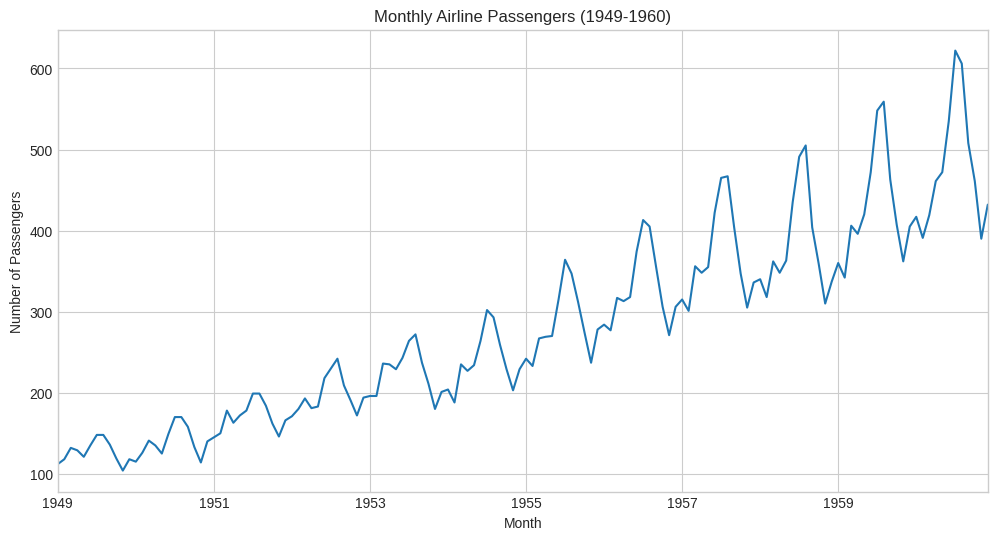

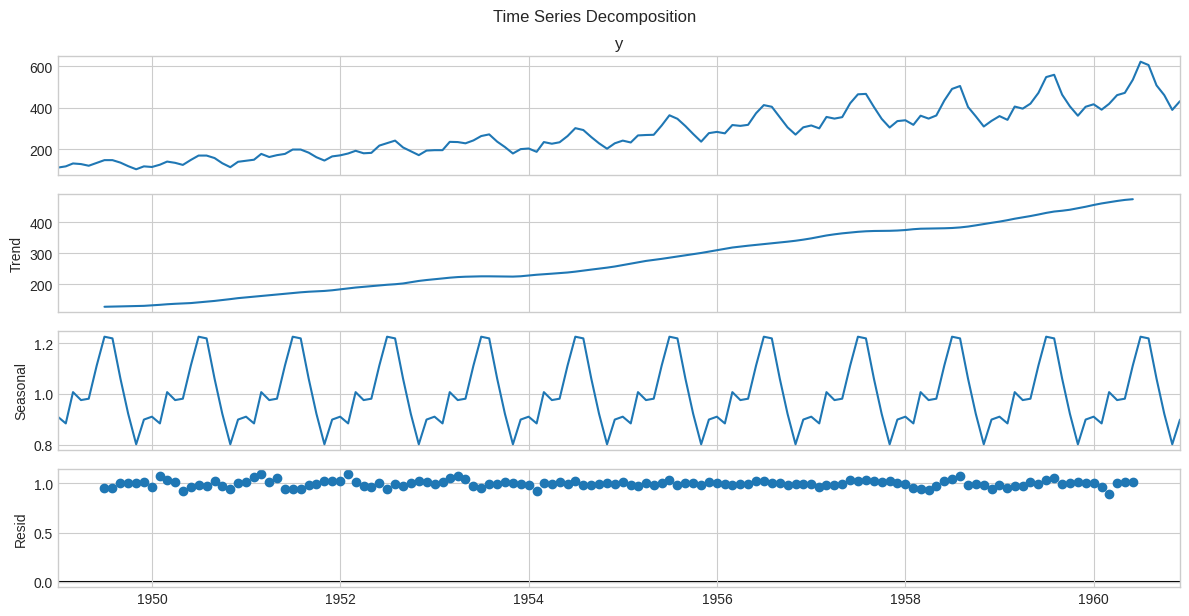

In [23]:
# 2. DATA EXPLORATION (EDA)
# ==============================================================================
print("\n--- Step 2: Exploratory Data Analysis ---")

# Plot the raw data
df['y'].plot(title='Monthly Airline Passengers (1949-1960)')
plt.ylabel('Number of Passengers')
plt.xlabel('Month')
plt.show()

# From the plot, we can clearly see:
# - A clear upward trend: people are flying more over time.
# - A strong yearly seasonality: there are peaks and troughs at the same time each year.

# Decompose the time series to visualize its components
decomposition = seasonal_decompose(df['y'], model='multiplicative') # Multiplicative is better when seasonality magnitude grows with the trend
fig = decomposition.plot()
plt.suptitle('Time Series Decomposition', y=1.02)
plt.show()

In [24]:
# 3. PREPROCESSING & STATIONARITY
# ==============================================================================
print("\n--- Step 3: Checking for Stationarity ---")
# Stationarity means the statistical properties of a series (mean, variance) are constant over time.
# ARIMA models assume that the time series is stationary.

def check_stationarity(timeseries):
    """
    Performs the Augmented Dickey-Fuller test to check for stationarity.
    """
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

print("\n--- Stationarity Check on Original Data ---")
check_stationarity(df['y'])
# The p-value is > 0.05, so we fail to reject the null hypothesis. The data is NOT stationary.

# To make the series stationary, we can use differencing.
# First, let's take the log transform to stabilize the variance.
df['y_log'] = np.log(df['y'])

# Then, we take the first difference to remove the trend.
df['y_log_diff'] = df['y_log'].diff().dropna()

print("\n--- Stationarity Check on Log-Transformed, First-Differenced Data ---")
check_stationarity(df['y_log_diff'].dropna())
# The p-value is now < 0.05. The series is stationary!




--- Step 3: Checking for Stationarity ---

--- Stationarity Check on Original Data ---
Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

--- Stationarity Check on Log-Transformed, First-Differenced Data ---
Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [25]:
# 4. MODEL BUILDING
# ==============================================================================
print("\n--- Step 4: Model Building ---")

# --- Data Splitting ---
# We'll use data up to the end of 1958 for training and the rest for testing (2 years).
train_size = len(df) - 24
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")


--- Step 4: Model Building ---
Training set size: 120
Test set size: 24



--- Finding Best SARIMA Parameters ---


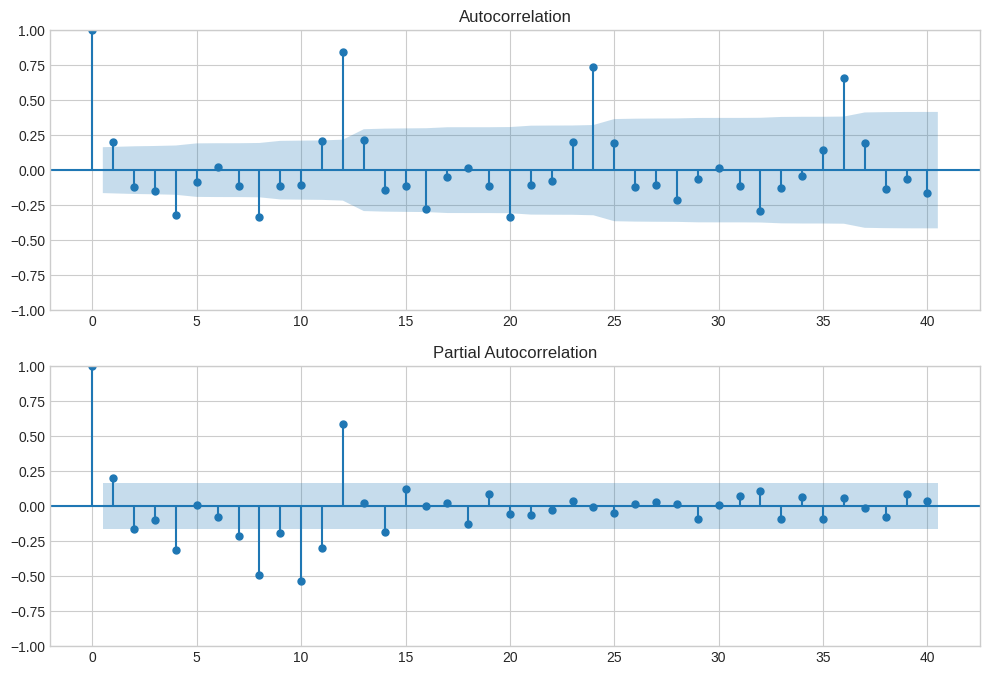

Searching for best SARIMA parameters...


/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: Valu

Best SARIMA Order: (0, 1, 1)
Best SARIMA Seasonal Order: (0, 1, 1, 12)
Best AIC: 707.5086518255501
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -350.754
Date:                            Tue, 15 Jul 2025   AIC                            707.509
Time:                                    09:33:38   BIC                            715.106
Sample:                                01-01-1949   HQIC                           710.576
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -

In [26]:
# # --- Model 1: SARIMA ---
# # Seasonal AutoRegressive Integrated Moving Average
# # We use auto_arima to automatically find the best (p,d,q)(P,D,Q,m) parameters.
# print("\n--- Fitting SARIMA Model ---")
# sarima_model = auto_arima(train['y'],
#                           start_p=1, start_q=1,
#                           test='adf',       # use adf test to find optimal 'd'
#                           max_p=3, max_q=3,
#                           m=12,             # 12 is the seasonal period (monthly data)
#                           start_P=0,
#                           seasonal=True,    # We know the data is seasonal
#                           d=None,           # let model determine 'd'
#                           D=1,              # let model determine 'D'
#                           trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True)

# print(sarima_model.summary())

# # Make predictions
# sarima_predictions = sarima_model.predict(n_periods=len(test))
# sarima_predictions = pd.Series(sarima_predictions, index=test.index)

# --- Model 1: SARIMA (with manual Grid Search) ---
# Seasonal AutoRegressive Integrated Moving Average
# Since we can't use auto_arima, we will perform a manual grid search for the best parameters.
print("\n--- Finding Best SARIMA Parameters ---")

# First, let's visualize ACF and PACF plots on the differenced data to get a hint.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['y_log_diff'].dropna(), ax=ax1, lags=40)
plot_pacf(df['y_log_diff'].dropna(), ax=ax2, lags=40)
plt.show()
# PACF suggests AR(1) or AR(2). ACF suggests MA(1).
# Seasonal spikes at 12, 24 suggest seasonal components are needed.

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, d, and q triplets
# We set m=12 for monthly seasonality
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

print("Searching for best SARIMA parameters...")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = SARIMAX(train['y'],
                                 order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            results = temp_model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except Exception as e:
            # print(f"Error with {param}/{param_seasonal}: {e}")
            continue

print(f"Best SARIMA Order: {best_pdq}")
print(f"Best SARIMA Seasonal Order: {best_seasonal_pdq}")
print(f"Best AIC: {best_aic}")

# Fit the best model and get the summary
sarima_model = best_model
print(sarima_model.summary())

# Make predictions
sarima_predictions = sarima_model.get_forecast(steps=len(test)).predicted_mean
sarima_predictions.index = test.index


In [27]:
# --- Model 2: Prophet ---
# Prophet is designed to handle time series with strong seasonal effects and trends.
print("\n--- Fitting Prophet Model ---")
# Prophet requires the dataframe to have specific column names: 'ds' for dates and 'y' for values.
prophet_train = train.reset_index().rename(columns={'Month': 'ds', 'y': 'y'})

prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.fit(prophet_train)

# Create a future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(test), freq='MS')
prophet_forecast = prophet_model.predict(future)

# Extract the predictions for the test period
prophet_predictions = prophet_forecast.iloc[-len(test):]['yhat']
prophet_predictions.index = test.index

09:33:52 - cmdstanpy - INFO - Chain [1] start processing
09:33:52 - cmdstanpy - INFO - Chain [1] done processing



--- Fitting Prophet Model ---


In [28]:
# --- Model 3: Gradient Boosting (XGBoost) ---
# XGBoost is a tree-based model, not a traditional time series model.
# We need to create features from the time index.
print("\n--- Fitting XGBoost Model ---")

def create_features(df_in):
    """Create time series features from a datetime index."""
    df_feat = df_in.copy()
    df_feat['month'] = df_feat.index.month
    df_feat['year'] = df_feat.index.year
    df_feat['quarter'] = df_feat.index.quarter
    # Add lag features - the largest lag determines how many rows we will lose
    df_feat['lag1'] = df_feat['y'].shift(1)
    df_feat['lag12'] = df_feat['y'].shift(12)
    return df_feat

# Create features on the entire dataset to allow lags to be computed correctly
df_feat = create_features(df)

# Drop rows with NaN values (which are at the beginning due to the lag features)
df_feat.dropna(inplace=True)

FEATURES = ['month', 'year', 'quarter', 'lag1', 'lag12']
TARGET = 'y'

# Re-split the data into training and testing sets from the feature-engineered dataframe
# The test set will be the last 24 rows, as originally intended.
test_size = len(test)
train_feat = df_feat.iloc[:-test_size]
test_feat = df_feat.iloc[-test_size:]


# Define and train the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    objective='reg:squarederror',
    early_stopping_rounds=10,
    n_jobs=-1
)

# Fit the model
xgb_model.fit(train_feat[FEATURES], train_feat[TARGET],
              eval_set=[(train_feat[FEATURES], train_feat[TARGET]), (test_feat[FEATURES], test_feat[TARGET])],
              verbose=False)

# Make predictions
xgb_predictions = xgb_model.predict(test_feat[FEATURES])
# Create a pandas Series with the correct index for plotting
xgb_predictions = pd.Series(xgb_predictions, index=test_feat.index)



--- Fitting XGBoost Model ---



--- Step 5: Model Evaluation ---
--- SARIMA Metrics ---
MSE: 5159.47
RMSE: 71.83
MAE: 66.28

--- Prophet Metrics ---
MSE: 923.38
RMSE: 30.39
MAE: 25.33

--- XGBoost Metrics ---
MSE: 3497.09
RMSE: 59.14
MAE: 49.36



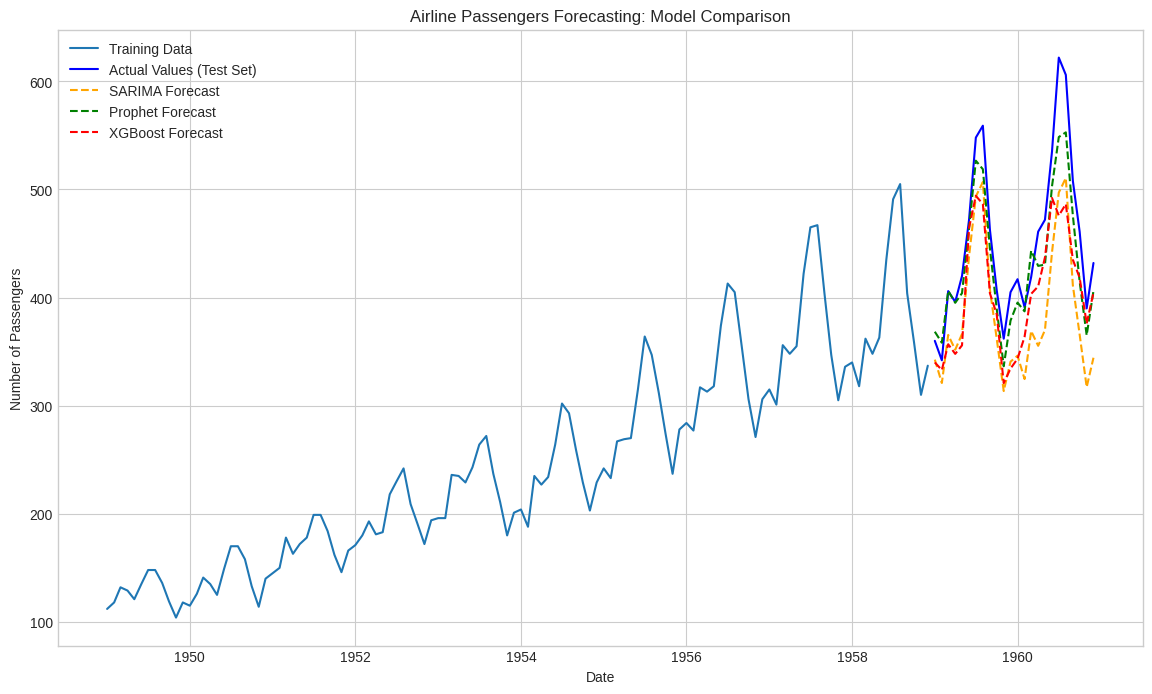

In [29]:
# 5. EVALUATION
# ==============================================================================
print("\n--- Step 5: Model Evaluation ---")

def calculate_metrics(true_values, predictions, model_name):
    """Calculates and prints MSE, RMSE, and MAE."""
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    print(f"--- {model_name} Metrics ---")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}\n")
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae}

# Calculate metrics for each model
sarima_metrics = calculate_metrics(test['y'], sarima_predictions, 'SARIMA')
prophet_metrics = calculate_metrics(test['y'], prophet_predictions, 'Prophet')
xgb_metrics = calculate_metrics(test['y'], xgb_predictions, 'XGBoost')

# --- Visualize the Forecasts ---
plt.figure(figsize=(14, 8))
plt.plot(train['y'], label='Training Data')
plt.plot(test['y'], label='Actual Values (Test Set)', color='blue')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='orange', linestyle='--')
plt.plot(prophet_predictions, label='Prophet Forecast', color='green', linestyle='--')
plt.plot(xgb_predictions, label='XGBoost Forecast', color='red', linestyle='--')

plt.title('Airline Passengers Forecasting: Model Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [30]:
# --- Summary Table ---
metrics_summary = pd.DataFrame([sarima_metrics, prophet_metrics, xgb_metrics])
print("\n--- Performance Summary ---")
print(metrics_summary.set_index('Model'))

print("\n--- Project Complete ---")
# In this case, SARIMA and Prophet performed very well, often outperforming XGBoost on
# this type of classic, regular time series. XGBoost can excel when there are many
# external features (regressors) to consider.


--- Performance Summary ---
              RMSE        MAE
Model                        
SARIMA   71.829443  66.275341
Prophet  30.387247  25.330075
XGBoost  59.136216  49.358593

--- Project Complete ---
